In [56]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


In [59]:
path="df_all.csv"

In [60]:
df= pd.read_csv(path)

In [61]:
df.head()

,Unnamed: 0,text,class
0,8,rt crooked hillary you didn't lose because yo...,explicit_hate
1,9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,34,are a bunch of religious bigots . i hope you e...,explicit_hate
3,45,hamas is the only one who lies and all those l...,explicit_hate
4,65,one of the questions never asked : if africans...,explicit_hate


In [62]:
# Combine classes for binary classification 

# Copy Dataframe first
df_binary_sample = df.copy()

# Replace classes 
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'not_hate'), 0, df_binary_sample['class'])
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'offensive'), 1, df_binary_sample['class'])
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'implicit_hate'), 1, df_binary_sample['class'])
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'explicit_hate'), 1, df_binary_sample['class'])

# show head 
df_binary_sample.head()


,Unnamed: 0,text,class
0,8,rt crooked hillary you didn't lose because yo...,1
1,9,"rt estonian pm : "" i don't want blacks in es...",1
2,34,are a bunch of religious bigots . i hope you e...,1
3,45,hamas is the only one who lies and all those l...,1
4,65,one of the questions never asked : if africans...,1


In [63]:
df2 = df_binary_sample.sample(frac=0.20) 

In [64]:
df2.shape

(12975, 3)

In [65]:
category_count = df2['class'].value_counts()

categories = category_count.index

categories

Int64Index([0, 1], dtype='int64')

In [66]:
import matplotlib.pyplot as plt

In [67]:
import seaborn as sns

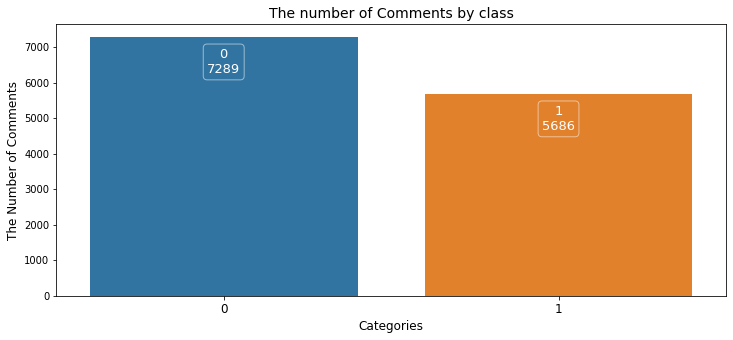

In [68]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 12)

plt.ylabel('The Number of Comments', size= 12)

plt.xticks(size = 12)

plt.title("The number of Comments by class" , size = 14)

plt.show()

In [69]:
#hate=1 not_hate=0

In [70]:
df2 = df2.dropna()

In [71]:
#df['text_cleaned'] = df['text'].str.replace('@[A-Za-z0-9]+\s?','', regex=True)

In [72]:
#df2['class_encoded'] = df2['class'].astype('category').cat.codes
#df2.head()

In [73]:
X=list(df2['text'])
#X=list(df['text_cleaned'])

In [74]:
y=list(df2['class'])

In [75]:
#y=list(pd.get_dummies(y,drop_first=True)['not_hate'])

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [77]:
from transformers import AlbertTokenizer
tokenizer = AlbertTokenizer.from_pretrained("vumichien/albert-base-v2-imdb")

In [78]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)


In [79]:
#convert it in to dataset object for tensorflow
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))



In [80]:

from transformers import TFAlbertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps = 10
    )

In [81]:
with training_args.strategy.scope():
    model = TFAlbertForSequenceClassification.from_pretrained("vumichien/albert-base-v2-imdb")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()

Downloading:   0%|          | 0.00/857 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some layers from the model checkpoint at vumichien/albert-base-v2-imdb were not used when initializing TFAlbertForSequenceClassification: ['dropout_857']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at vumichien/albert-base-v2-imdb.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.8/dist-packages/t

In [82]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.2883032816319378}

In [83]:
#trainer.predict(test_dataset)

In [84]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

In [85]:
output.shape

(2593,)

In [86]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,output)
cm

array([[1358,  102],
       [ 253,  880]])

In [87]:

pd.DataFrame(output).to_csv('output.csv') 

In [88]:

pd.DataFrame(y).to_csv('y.csv') 

In [89]:

pd.DataFrame(X).to_csv('X.csv') 

In [90]:
trainer.save_model('senti_model')

In [91]:
# model's performance
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1460
           1       0.90      0.78      0.83      1133

    accuracy                           0.86      2593
   macro avg       0.87      0.85      0.86      2593
weighted avg       0.87      0.86      0.86      2593



In [92]:
import matplotlib.pyplot as plt

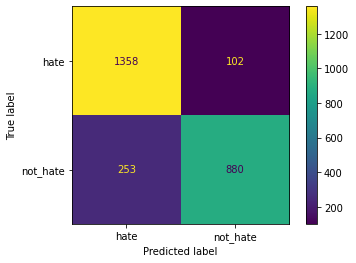

In [93]:
from sklearn import metrics
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, output)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["hate", "not_hate"])

cm_display.plot()

In [94]:
Precision = metrics.precision_score(y_test, output)

print(Precision)

0.8961303462321792


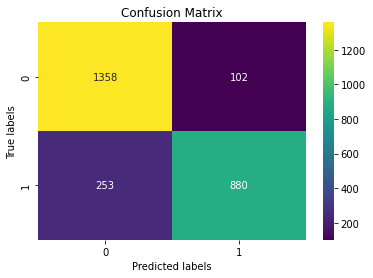

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='viridis')  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 